# Precipitation: Evolving the Full Context

In this notebook, the goal is to predict the total precipitation in Netherlands given previous climatological information (mean sea level pressure, sea surface temperature, 2-meter temperature, and relative humidity). In particular, this will be done with the following approach:

- The global data will be considered (that is, not only Netherlands data)
- The data will be clustered in order to reduce the dimensionality of the problem (the number of clusters will be 20)
- Each cluster may have a different time lag (that is, the precipitation in a given cluster may depend on the climatological information of cluster A from 1 week ago, but on the climatological information of cluster B from 2 weeks ago)
- Each cluster may have a temporal series of different length (that is, the time series of cluster A may have 10 time steps, but the time series of cluster B may have 20 time steps).
- Not every cluster will be considered.

The goal is to use CRO to evolve these decision parameters.

# 0. Setup

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gheode_methodology.utils import filter_dataset

In [37]:
attr_names = ["msl", "sst", "t2m", "r"]
n_attrs = len(attr_names)
K = 20

In [38]:
df = pd.read_csv("../data/dataframe_lag-1_K-20_no-cnorm.csv")
df

,msl_cc_0,msl_cc_1,msl_cc_2,msl_cc_3,msl_cc_4,msl_cc_5,msl_cc_6,msl_cc_7,msl_cc_8,msl_cc_9,...,r_zi_4,r_zi_5,r_zi_6,r_zi_7,r_zi_8,season_spring,season_summer,season_fall,season_winter,target_tp
0,102774.555,101606.375,98541.695,101836.300,99910.760,100295.000,100460.020,99184.375,101447.875,98987.920,...,68.434320,66.696840,59.167236,62.127750,68.537285,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47,10.838032
1,102459.890,101584.625,99628.336,101911.490,100081.980,98412.050,100312.020,98978.260,101578.240,99226.920,...,66.899610,65.824780,71.189850,69.310520,62.125670,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102349.240,101803.770,98930.180,101894.990,99196.650,100259.836,100020.010,99459.800,101498.125,98302.250,...,67.228530,63.367638,71.111580,69.913960,71.185570,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490190
3,102926.700,101689.390,99140.150,101886.310,99155.920,101464.040,99953.580,99241.080,101454.734,98632.950,...,60.181490,61.059868,61.021870,60.930157,58.795002,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102328.960,101663.460,100456.830,101808.450,99623.490,102716.390,100536.350,99358.260,101338.950,98710.230,...,44.702656,39.775370,31.059680,29.233988,27.226520,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102507.270,101810.750,99068.060,101762.170,98799.305,101092.680,99126.300,98299.336,101412.920,97048.560,...,61.932987,60.554268,60.000250,60.375908,59.757930,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,102261.740,101758.195,99227.620,101880.180,98722.750,101230.040,99360.040,98416.890,101535.336,97774.830,...,69.912476,72.905800,67.913280,71.166680,70.885010,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,103018.760,101737.760,99095.070,101949.290,98030.350,99875.266,98778.375,99664.710,101689.150,96022.040,...,68.518060,59.579770,68.117645,68.000570,65.350370,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102185.870,101826.180,99705.055,102001.664,99230.130,101261.820,100426.080,99764.640,101544.945,97012.445,...,28.756506,29.183332,35.088260,34.982582,34.433987,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


In [46]:
filter_dataset(df, K, attr_names,
               np.zeros((n_attrs, K), dtype=int),
               np.ones((n_attrs, K), dtype=int),
               np.ones(K, dtype=int),
               cols_to_maintain=["season_spring", "season_summer",
                                 "season_fall", "season_winter",
                                 "target_tp"])

,msl_cm_0_t-0,msl_cm_1_t-0,msl_cm_2_t-0,msl_cm_3_t-0,msl_cm_4_t-0,msl_cm_5_t-0,msl_cm_6_t-0,msl_cm_7_t-0,msl_cm_8_t-0,msl_cm_9_t-0,...,r_cm_15_t-0,r_cm_16_t-0,r_cm_17_t-0,r_cm_18_t-0,r_cm_19_t-0,season_spring,season_summer,season_fall,season_winter,target_tp
0,103090.590,101724.164,98926.305,101861.410,99846.530,99810.586,100415.305,98989.080,101422.140,98794.750,...,18.857190,22.704771,58.303852,52.721592,27.370834,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47,10.838032
1,102677.300,101717.360,99040.730,101758.560,99945.030,99125.040,100351.260,99111.050,101581.310,98685.625,...,21.208904,28.722164,55.893200,47.796990,32.511936,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102858.920,101502.336,99118.150,101684.250,99063.940,100443.430,99927.734,99424.260,101599.140,98173.880,...,19.850100,27.997900,56.768948,45.284412,32.245950,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490190
3,102709.290,101676.260,99212.820,101710.016,99070.540,101535.910,99963.945,99213.125,101571.890,98488.766,...,17.950554,22.461882,60.609000,49.308823,28.185429,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102038.390,101644.234,99260.590,101637.290,99481.990,102065.180,100494.960,99387.914,101462.734,98087.840,...,20.396734,15.064026,59.844296,51.325510,30.773876,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102211.230,101624.250,99556.930,101931.280,98607.580,100631.610,99133.360,98419.914,101454.445,97057.195,...,32.771240,22.509802,54.039860,43.926567,27.644203,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,101878.734,101670.086,99619.110,102229.090,98700.375,101350.630,99509.360,98622.445,101546.790,97557.810,...,27.779730,21.583252,55.731567,43.414482,29.627197,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,102575.555,101654.836,99591.100,102163.875,98081.260,100938.530,98920.540,99614.670,101751.875,96540.900,...,17.201233,17.878101,57.052864,46.217674,27.976473,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102259.330,101817.350,99190.750,101999.240,99295.060,100804.516,100490.660,99591.990,101464.664,97173.310,...,24.867264,21.863613,54.616405,43.839226,27.970680,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


In [45]:
filter_dataset(df, K, attr_names,
               np.random.randint(1, 5, (n_attrs, K)),
               np.random.randint(1, 5, (n_attrs, K)),
               np.random.randint(0, 2, K),
               cols_to_maintain=["season_spring", "season_summer",
                                 "season_fall", "season_winter",
                                 "target_tp"])

,msl_cm_1_t-4,msl_cm_1_t-5,msl_cm_1_t-6,msl_cm_1_t-7,msl_cm_2_t-1,msl_cm_2_t-2,msl_cm_6_t-1,msl_cm_7_t-2,msl_cm_7_t-3,msl_cm_7_t-4,...,r_cm_14_t-3,r_cm_14_t-4,r_cm_15_t-1,r_cm_17_t-3,r_cm_19_t-3,season_spring,season_summer,season_fall,season_winter,target_tp
7,101676.260,101502.336,101717.360,101724.164,99846.650,99763.030,100377.010,99239.130,99387.914,99213.125,...,77.519270,76.012150,18.026423,59.844296,30.773876,2.212161e+01,1.289572e-03,3.439519e-15,4.197329e-34,19.899845
8,101644.234,101676.260,101502.336,101717.360,99093.320,99846.650,100902.830,98658.440,99239.130,99387.914,...,70.147640,77.519270,23.447912,59.789375,27.552933,2.325581e+01,4.974428e-03,4.868308e-14,2.179898e-32,26.686907
9,101787.914,101644.234,101676.260,101502.336,99632.125,99093.320,99917.970,99477.640,98658.440,99239.130,...,63.209194,70.147640,19.791840,56.756203,29.888031,2.212161e+01,1.736246e-02,6.234893e-13,1.024401e-30,13.228655
10,101887.734,101787.914,101644.234,101676.260,99459.710,99632.125,101131.750,99116.060,99477.640,98658.440,...,78.130650,63.209194,19.348621,64.225630,27.540524,1.904025e+01,5.483400e-02,7.225210e-12,4.355863e-29,30.650139
11,101816.790,101887.734,101787.914,101644.234,99714.850,99459.710,100247.170,98669.510,99116.060,99477.640,...,79.054840,78.130650,22.083567,58.593790,26.362940,1.482856e+01,1.566964e-01,7.576044e-11,1.675904e-27,8.272886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,101664.734,101719.320,101503.875,101744.695,99302.750,100249.310,99959.414,98712.305,98348.000,97408.630,...,74.318510,79.452770,33.308754,49.068190,27.573902,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,101715.870,101664.734,101719.320,101503.875,99556.930,99302.750,99133.360,99788.700,98712.305,98348.000,...,81.222725,74.318510,32.771240,48.785793,27.970660,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,101771.240,101715.870,101664.734,101719.320,99619.110,99556.930,99509.360,98419.914,99788.700,98712.305,...,70.668960,81.222725,27.779730,50.223614,28.013445,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,101785.960,101771.240,101715.870,101664.734,99591.100,99619.110,98920.540,98622.445,98419.914,99788.700,...,80.488235,70.668960,17.201233,54.039860,27.644203,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


# 1. Supervised Learning functions

In [13]:
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [14]:
def get_X_y(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    return X, y

In [15]:
def get_train_test(df, random_state=0):
    X, y = get_X_y(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [16]:
def get_mse(df, model=LinearRegression(), simulations=10):
    errors_train = []
    errors_test = []
    errors_cv_train = []
    errors_cv_test = []

    for i in range(simulations):
        X_train, X_test, y_train, y_test = get_train_test(df, random_state=i)

        model.fit(X_train, y_train)

        error_train = mean_squared_error(y_train, model.predict(X_train))
        error_test = mean_squared_error(y_test, model.predict(X_test))

        cv_results = cross_validate(model, X_train, y_train, cv=KFold(10, shuffle=True, random_state=i*2), scoring="neg_mean_squared_error", return_train_score=True, )
        error_cv_train = - cv_results["train_score"].mean()
        error_cv_val = - cv_results["test_score"].mean()

        errors_train.append(error_train)
        errors_test.append(error_test)
        errors_cv_train.append(error_cv_train)
        errors_cv_test.append(error_cv_val)

    return np.array(errors_train).mean(), np.array(errors_cv_train).mean(), np.array(errors_cv_test).mean(), np.array(errors_test).mean()

In [17]:
def plot_model(df, model, random_state=None):
    X, y = get_X_y(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X = scaler.transform(X)

    model.fit(X_train, y_train)
    y_pred = model.predict(X)

    plt.figure(figsize=(14, 6))
    plt.plot(y.to_numpy(), label="train", color='blue')
    plt.plot(y_pred, label="pred train", color='red')
    plt.xlabel("Time")
    plt.ylabel("Total precipitation (weekly)")
    plt.legend()
    plt.show()

In [19]:
df = pd.read_csv("../data/global-weekly_clustermeans_K20_no-cnorm.csv")
df = df.dropna()
df

,msl_cm_0,msl_cm_1,msl_cm_2,msl_cm_3,msl_cm_4,msl_cm_5,msl_cm_6,msl_cm_7,msl_cm_8,msl_cm_9,...,rh_cm_15,rh_cm_16,rh_cm_17,rh_cm_18,rh_cm_19,season_spring,season_summer,season_fall,season_winter,target_tp
0,103090.590,101724.164,98926.305,101861.410,99846.530,99810.586,100415.305,98989.080,101422.140,98794.750,...,18.857190,22.704771,58.303852,52.721592,27.370834,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47,10.838032
1,102677.300,101717.360,99040.730,101758.560,99945.030,99125.040,100351.260,99111.050,101581.310,98685.625,...,21.208904,28.722164,55.893200,47.796990,32.511936,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102858.920,101502.336,99118.150,101684.250,99063.940,100443.430,99927.734,99424.260,101599.140,98173.880,...,19.850100,27.997900,56.768948,45.284412,32.245950,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490190
3,102709.290,101676.260,99212.820,101710.016,99070.540,101535.910,99963.945,99213.125,101571.890,98488.766,...,17.950554,22.461882,60.609000,49.308823,28.185429,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102038.390,101644.234,99260.590,101637.290,99481.990,102065.180,100494.960,99387.914,101462.734,98087.840,...,20.396734,15.064026,59.844296,51.325510,30.773876,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102211.230,101624.250,99556.930,101931.280,98607.580,100631.610,99133.360,98419.914,101454.445,97057.195,...,32.771240,22.509802,54.039860,43.926567,27.644203,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,101878.734,101670.086,99619.110,102229.090,98700.375,101350.630,99509.360,98622.445,101546.790,97557.810,...,27.779730,21.583252,55.731567,43.414482,29.627197,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,102575.555,101654.836,99591.100,102163.875,98081.260,100938.530,98920.540,99614.670,101751.875,96540.900,...,17.201233,17.878101,57.052864,46.217674,27.976473,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102259.330,101817.350,99190.750,101999.240,99295.060,100804.516,100490.660,99591.990,101464.664,97173.310,...,24.867264,21.863613,54.616405,43.839226,27.970680,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


### 1.1. Dummy model

error_train    : 	332.07789091052086
error_cv_train: 	332.05341898532754
error_cv_test  : 	332.5266498808324
error_test    : 	326.13340651824035


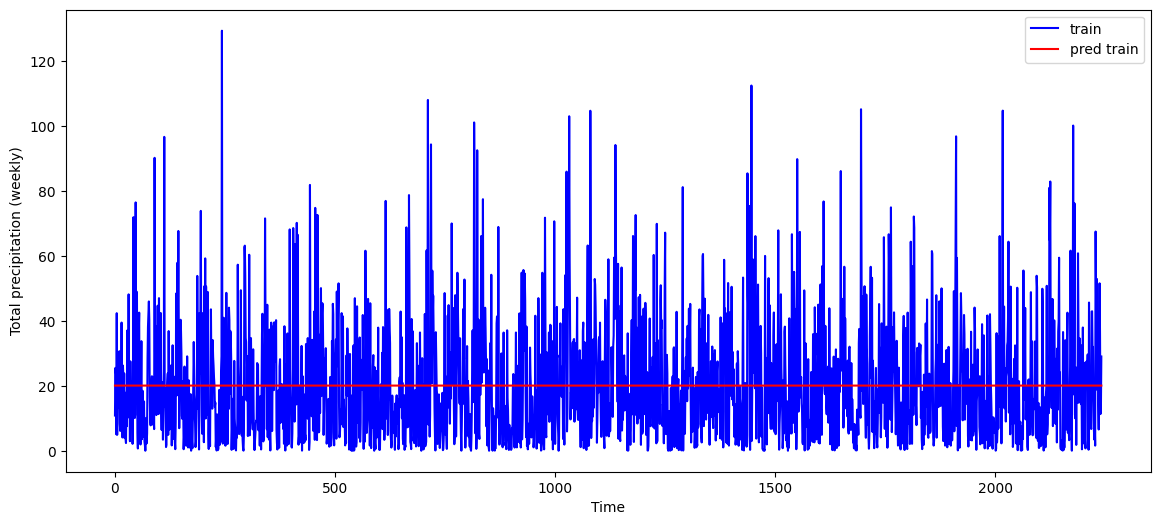

In [15]:
df_ = df.iloc[:, :]
model = DummyRegressor()
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(df_, model)):
    print(f"{name}: \t{val}")
plot_model(df_, model)

### 1.2. Linear Regression

#### Only weather data

error_train    : 	312.4553640275338
error_cv_train: 	312.37617555126087
error_cv_test  : 	313.9466542930161
error_test    : 	313.5320388962696


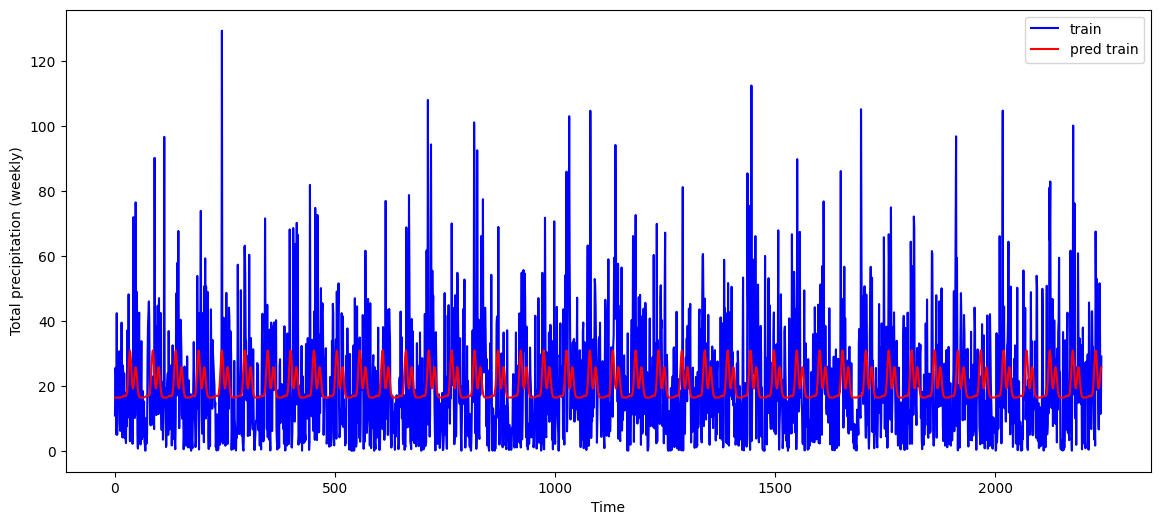

In [16]:
df_ = df.iloc[:, -4:]
model = LinearRegression()
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(df_, model)):
    print(f"{name}: \t{val}")
plot_model(df_, model)

#### All data

error_train    : 	275.14751445143395
error_cv_train: 	273.69962076494903
error_cv_test  : 	303.4236888010265
error_test    : 	297.7226462215965


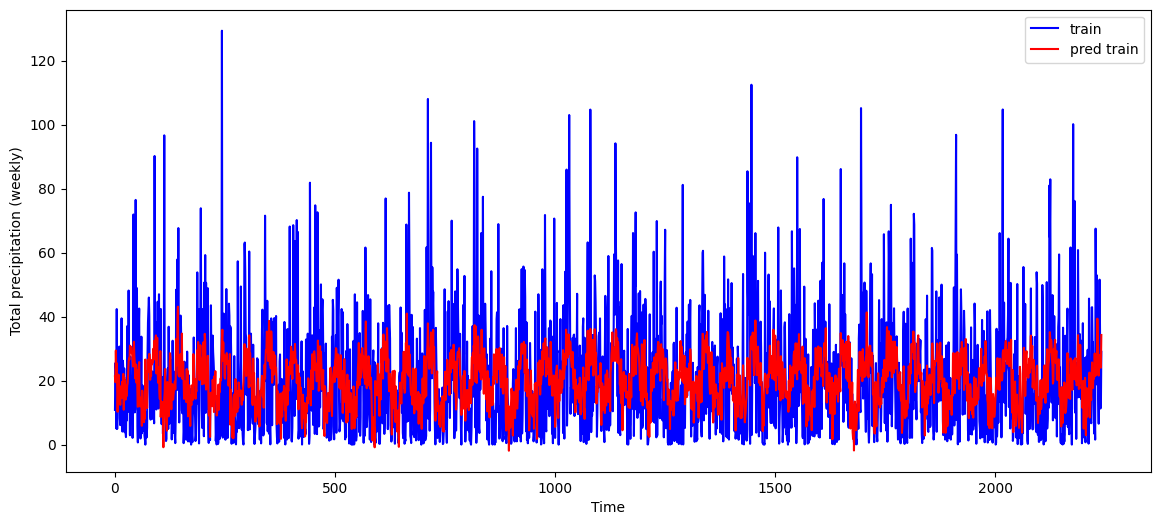

In [17]:
df_ = df.iloc[:, :]
model = LinearRegression()
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(df_, model, 10)):
    print(f"{name}: \t{val}")
plot_model(df_, model)

error_train    : 	274.6163555896165
error_cv_train: 	273.13734900906155
error_cv_test  : 	303.5418021606808
error_test    : 	299.78775763145217


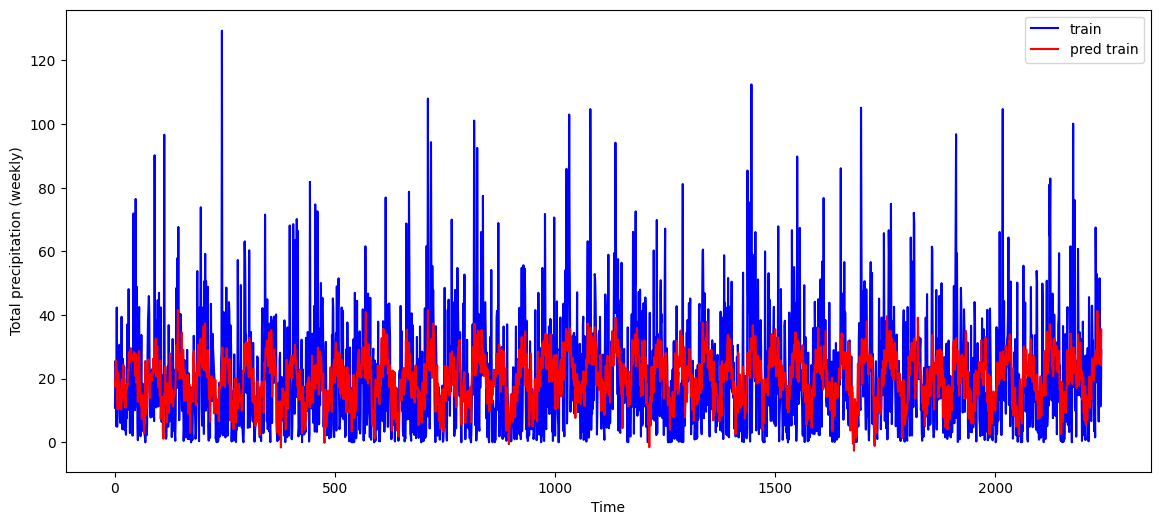

In [18]:
df_ = df.iloc[:, :]
model = LinearRegression()
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(df_, model, 50)):
    print(f"{name}: \t{val}")
plot_model(df_, model)

### Using timestep = 2

error_train    : 	262.2723872459445
error_cv_train: 	259.3972165228409
error_cv_test  : 	320.1375183099363
error_test    : 	316.50558745859854


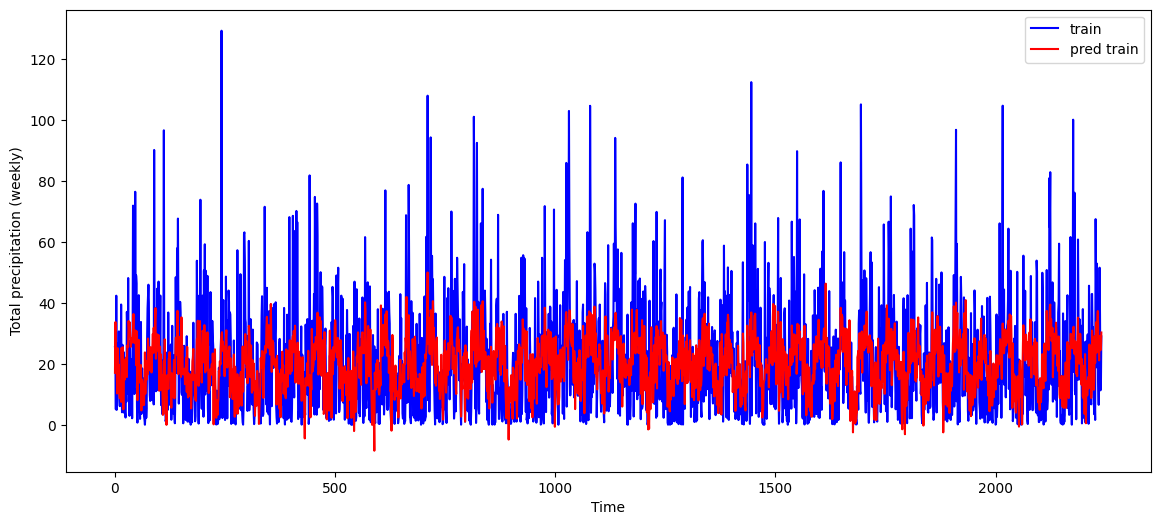

In [19]:
df_ = get_dataset(df, np.zeros((n_attrs, K), dtype=int), np.ones((n_attrs, K), dtype=int) * 2, np.ones(K, dtype=int))
model = LinearRegression()
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(df_, model, 50)):
    print(f"{name}: \t{val}")
plot_model(df_, model)

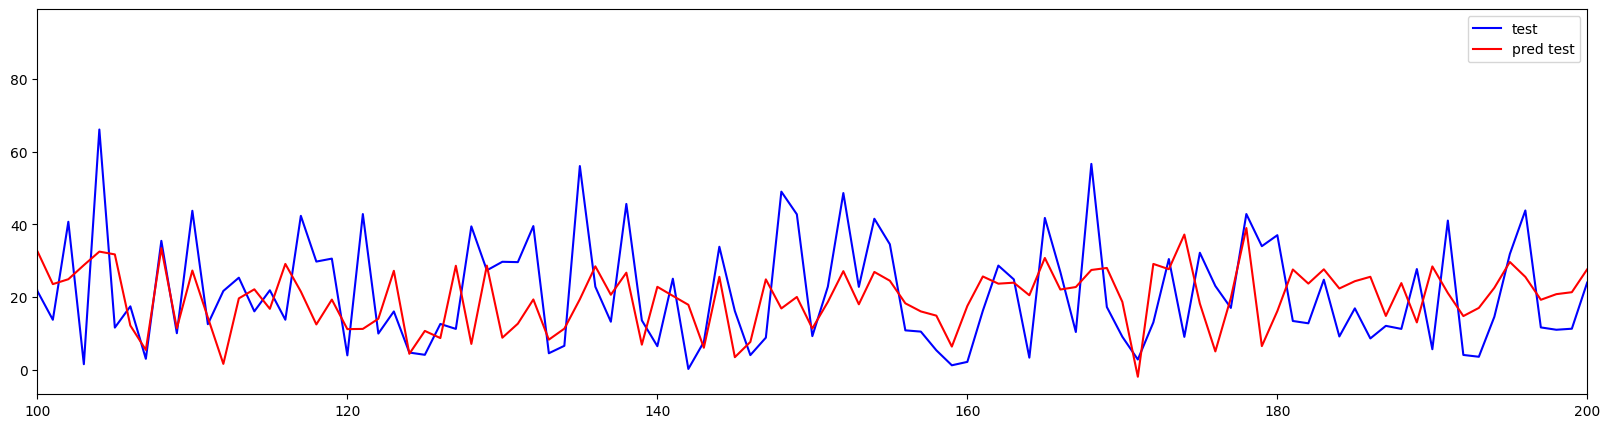

In [20]:
X_train, X_test, y_train, y_test = get_train_test(df_)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

plt.figure(figsize=(20, 5))
# plt.plot(y_train.to_numpy(), label="train", color='blue')
# plt.plot(y_pred_train, label="pred train", color='red')
plt.plot(y_test.to_numpy(), label="test", color='blue')
plt.plot(y_pred_test, label="pred test", color='red')
plt.xlim(100, 200)
plt.legend()
plt.show()

### Using timestep = 4

error_train    : 	235.70049036514837
error_cv_train: 	230.04491926966656
error_cv_test  : 	357.34099469645616
error_test    : 	341.2938226596414


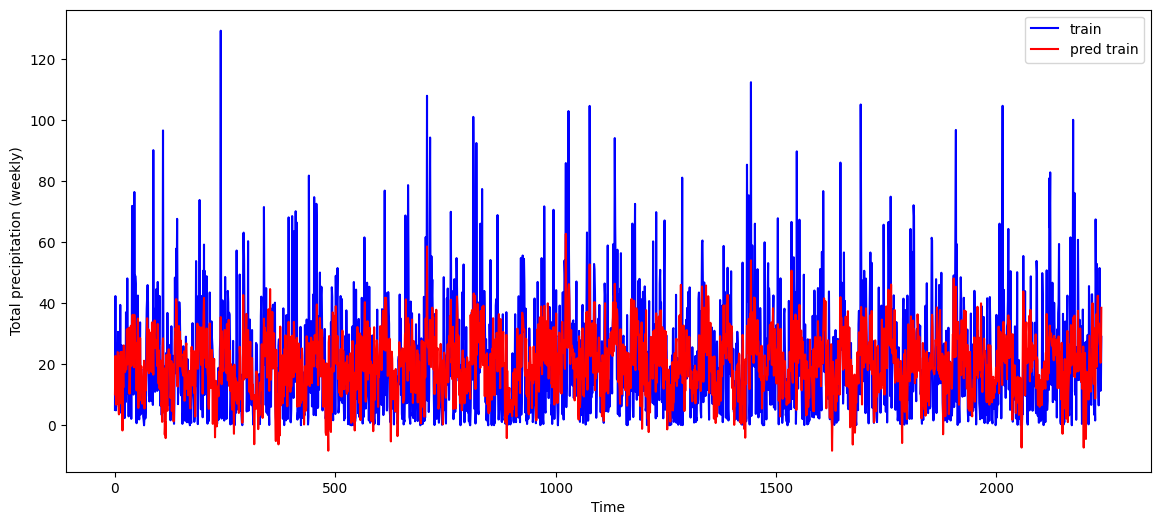

In [21]:
df_ = get_dataset(df, np.zeros((n_attrs, K), dtype=int), np.ones((n_attrs, K), dtype=int) * 4, np.ones(K, dtype=int))
model = LinearRegression()
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(df_, model, 50)):
    print(f"{name}: \t{val}")
plot_model(df_, model)

### Random

error_train    : 	287.5491452219053
error_cv_train: 	285.7237710539209
error_cv_test  : 	323.2938141560544
error_test    : 	319.4408259510025


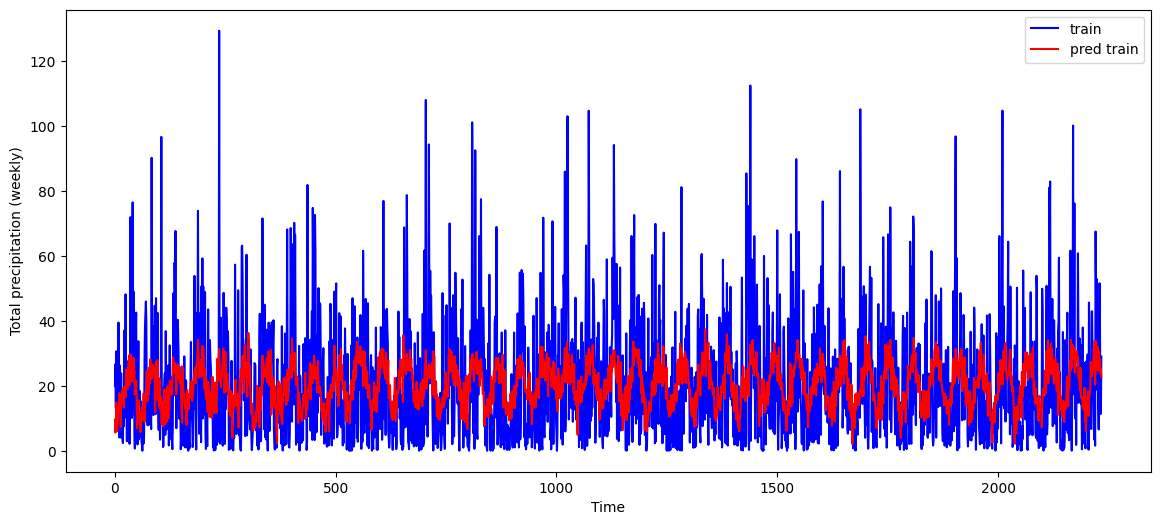

In [31]:
df_ = get_dataset(df, np.random.randint(1, 5, (4, 20)), np.random.randint(1, 5, (4, 20)), np.random.randint(0, 2, K))
model = LinearRegression()
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(df_, model, 50)):
    print(f"{name}: \t{val}")
plot_model(df_, model)

error_train    : 	293.8571177727797
error_cv_train: 	292.6995934032581
error_cv_test  : 	316.3268084013735
error_test    : 	315.4727550803529


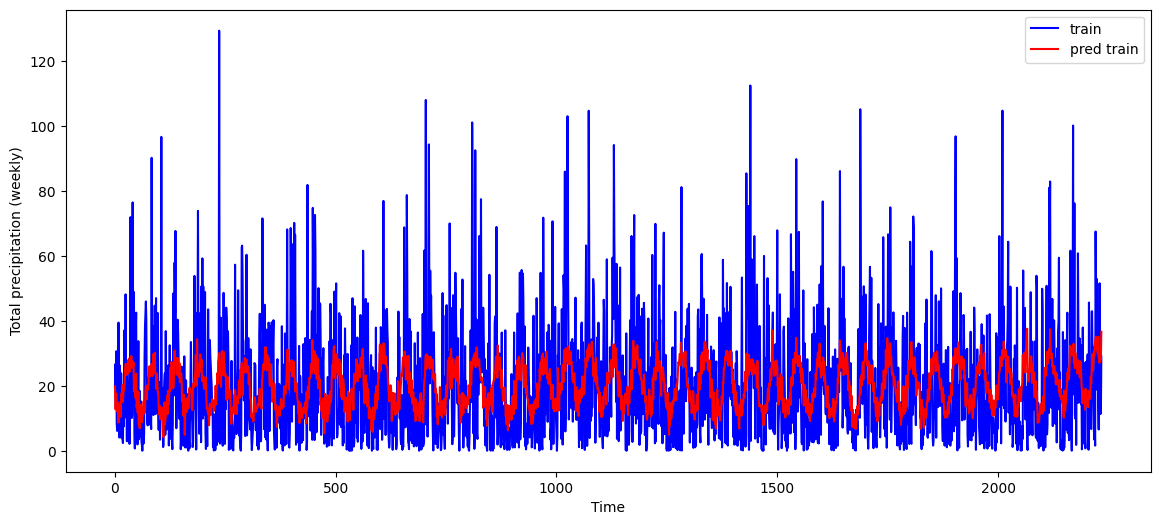

In [32]:
df_ = get_dataset(df, np.random.randint(1, 5, (4, 20)), np.random.randint(1, 5, (4, 20)), np.random.randint(0, 2, K))
model = LinearRegression()
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(df_, model, 50)):
    print(f"{name}: \t{val}")
plot_model(df_, model)

## 2. Evaluating the correlation between the errors

In [ ]:
from scipy.stats import pearsonr
import time

10/50...
20/50...
30/50...
40/50...
50/50...


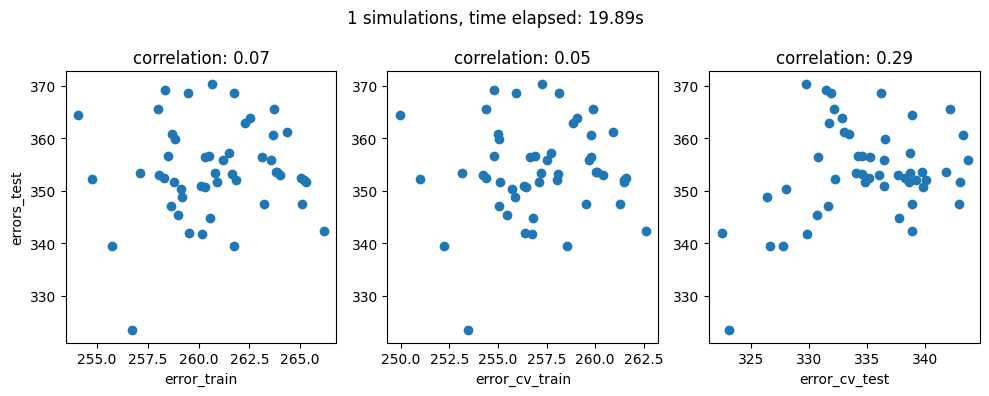

10/50...
20/50...
30/50...
40/50...
50/50...


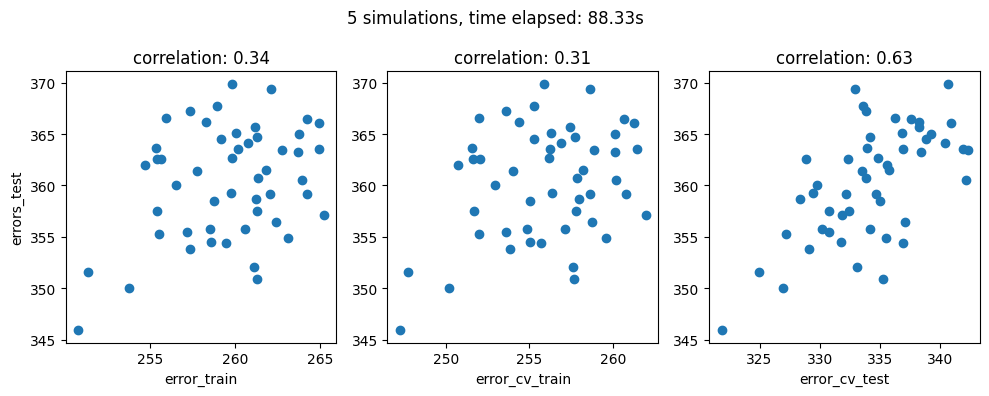

10/50...
20/50...
30/50...
40/50...
50/50...


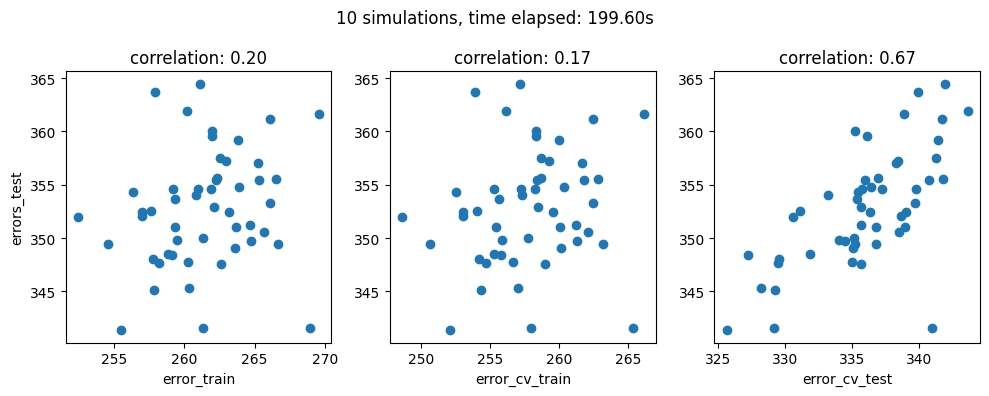

10/50...
20/50...
30/50...
40/50...
50/50...


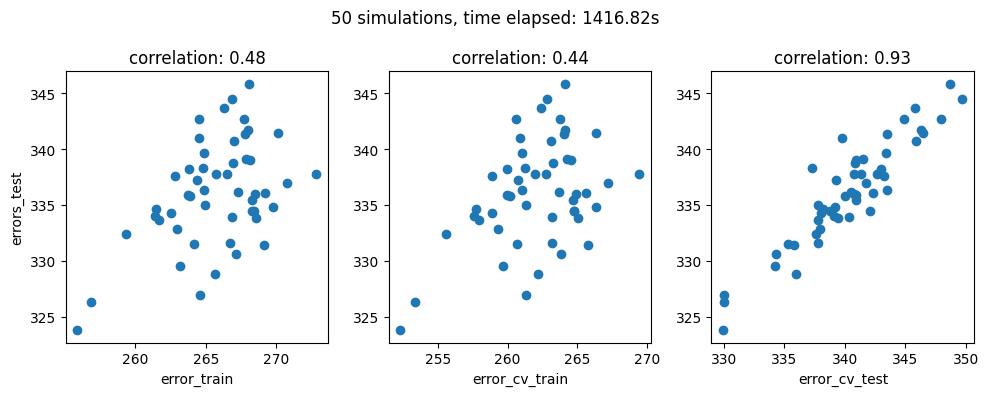

In [38]:
plot_points = 50

for cv_simuls in [1, 5, 10, 50]:
    errors = []

    tik = time.perf_counter()
    for i in range(plot_points):
        if (i + 1) % 10 == 0:
            print(f"{i+1}/{plot_points}...")
        df_ = get_dataset(df, np.random.randint(0, 5, (4, 20)), np.random.randint(1, 5, (4, 20)), np.ones(K))
        model = LinearRegression()
        errors.append(get_mse(df_, model, cv_simuls))
    tok = time.perf_counter()

    errors_train, errors_cv_train, errors_cv_test, errors_test = zip(*errors)

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].scatter(errors_train, errors_test)
    axs[0].set_xlabel("error_train")
    axs[0].set_ylabel("errors_test")
    pr = pearsonr(errors_train, errors_test)
    axs[0].set_title(f"correlation: {pr[0]:.2f}")

    axs[1].scatter(errors_cv_train, errors_test)
    axs[1].set_xlabel("error_cv_train")
    pr = pearsonr(errors_cv_train, errors_test)
    axs[1].set_title(f"correlation: {pr[0]:.2f}")

    axs[2].scatter(errors_cv_test, errors_test)
    axs[2].set_xlabel("error_cv_test")
    pr = pearsonr(errors_cv_test, errors_test)
    axs[2].set_title(f"correlation: {pr[0]:.2f}")

    plt.suptitle(f"{cv_simuls} simulations, time elapsed: {tok - tik:.2f}s")
    plt.tight_layout()
    plt.show()

10/50...
20/50...
30/50...
40/50...
50/50...


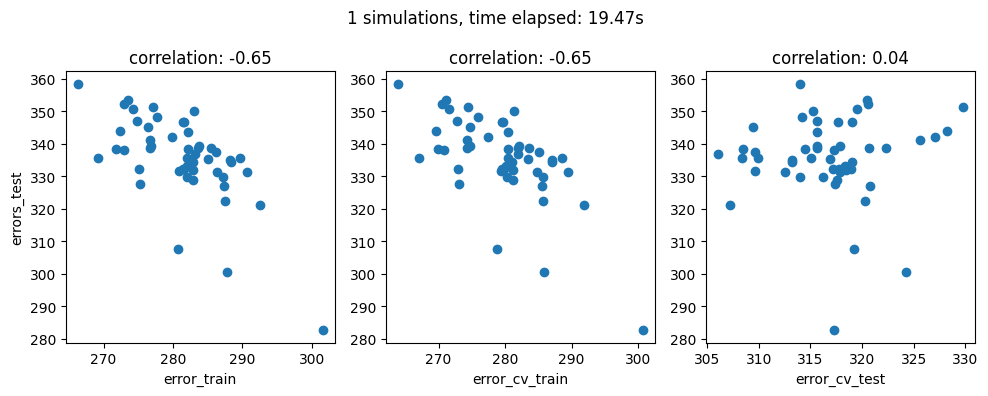

10/50...
20/50...
30/50...
40/50...
50/50...


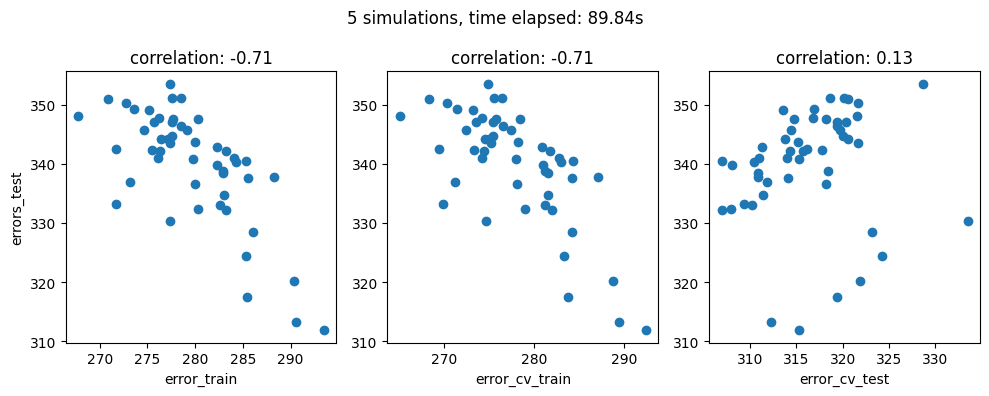

10/50...
20/50...
30/50...
40/50...
50/50...


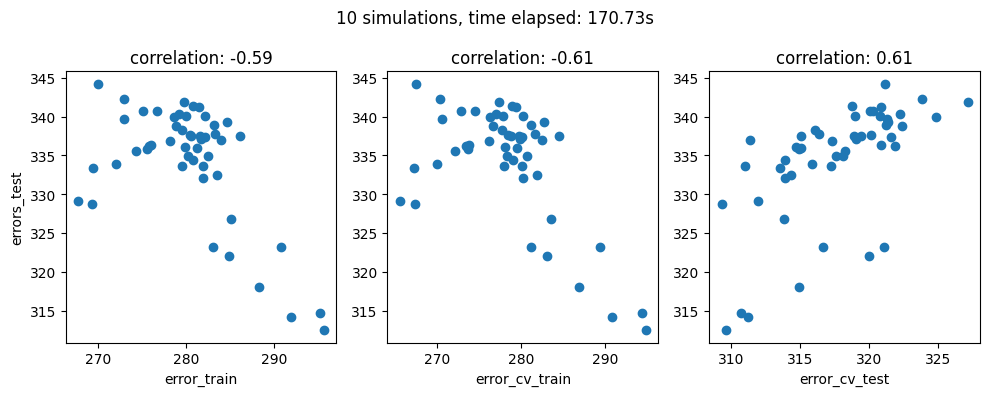

10/50...
20/50...
30/50...
40/50...
50/50...


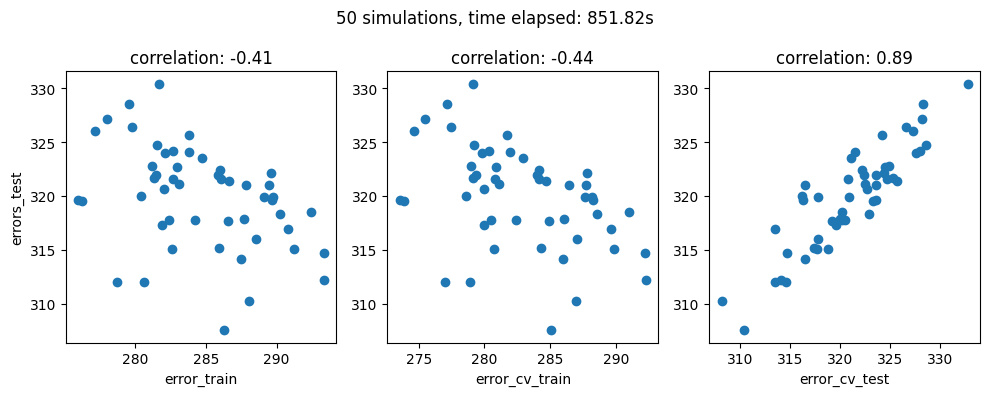

In [39]:
plot_points = 50

for cv_simuls in [1, 5, 10, 50]:
    errors = []

    tik = time.perf_counter()
    for i in range(plot_points):
        if (i + 1) % 10 == 0:
            print(f"{i+1}/{plot_points}...")
        df_ = get_dataset(df, np.random.randint(0, 5, (4, 20)), np.random.randint(1, 5, (4, 20)), np.random.randint(0, 2, (K)))
        model = LinearRegression()
        errors.append(get_mse(df_, model, cv_simuls))
    tok = time.perf_counter()

    errors_train, errors_cv_train, errors_cv_test, errors_test = zip(*errors)

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].scatter(errors_train, errors_test)
    axs[0].set_xlabel("error_train")
    axs[0].set_ylabel("errors_test")
    pr = pearsonr(errors_train, errors_test)
    axs[0].set_title(f"correlation: {pr[0]:.2f}")

    axs[1].scatter(errors_cv_train, errors_test)
    axs[1].set_xlabel("error_cv_train")
    pr = pearsonr(errors_cv_train, errors_test)
    axs[1].set_title(f"correlation: {pr[0]:.2f}")

    axs[2].scatter(errors_cv_test, errors_test)
    axs[2].set_xlabel("error_cv_test")
    pr = pearsonr(errors_cv_test, errors_test)
    axs[2].set_title(f"correlation: {pr[0]:.2f}")

    plt.suptitle(f"{cv_simuls} simulations, time elapsed: {tok - tik:.2f}s")
    plt.tight_layout()
    plt.show()

## 2. Using CRO to evolve the lag times and time steps

In [77]:
from PyCROSL.CRO_SL import CRO_SL
from PyCROSL.AbsObjectiveFunc import AbsObjectiveFunc
from PyCROSL.SubstrateInt import SubstrateInt


class LinearRegressionMse(AbsObjectiveFunc):
    def __init__(self, size, K, fitness_simulations=10):
        self.size = size
        self.lag_time_size = (size - K) // 2
        self.time_step_size = (size - K) // 2
        self.mask_size = K

        self.K = K
        self.fitness_simulations = fitness_simulations

        self.opt = "min"

        self.lag_time_max = 4
        self.lag_time_min = 0
        self.time_step_max = 4
        self.time_step_min = 1
        self.sup_lim = np.concatenate((np.full(self.lag_time_size, self.lag_time_max + 1),
                                       np.full(self.time_step_size, self.time_step_max + 1),
                                       np.full(self.mask_size, 2)))
        self.inf_lim = np.concatenate((np.full(self.lag_time_size, self.lag_time_min),
                                       np.full(self.time_step_size, self.time_step_min),
                                       np.full(self.mask_size, 0)))

        super().__init__(self.size, self.opt, self.sup_lim, self.inf_lim)

    def convert_solution_to_data(self, solution):
        lag_times = np.reshape(solution[:self.lag_time_size], (n_attrs, K))
        time_steps = np.reshape(solution[self.lag_time_size:(self.lag_time_size + self.time_step_size)], (n_attrs, K))
        masks = np.reshape(solution[(self.lag_time_size + self.time_step_size):], K)

        return lag_times, time_steps, masks

    def objective(self, solution):
        data = get_dataset(df, *self.convert_solution_to_data(solution))
        mse_train, mse_cv_train, mse_cv_test, mse_test = get_mse(data, LinearRegression(), simulations=self.fitness_simulations)

        return mse_cv_test

    def random_solution(self):
        lag_times = np.random.randint(self.lag_time_min, self.lag_time_max + 1, self.lag_time_size)
        time_steps = np.random.randint(self.time_step_min, self.time_step_max + 1, self.time_step_size)
        masks = np.random.randint(0, 2, self.mask_size)
        return np.concatenate((lag_times, time_steps, masks))

    def repair_solution(self, solution):
        return np.clip(solution, self.inf_lim, self.sup_lim)

In [78]:
LinearRegressionMse((n_attrs * K) * 2 + K, K).random_solution()

array([1, 4, 2, 3, 1, 1, 1, 4, 3, 1, 1, 4, 0, 0, 2, 4, 1, 3, 4, 0, 4, 0,
       3, 4, 1, 0, 3, 1, 1, 0, 4, 0, 3, 4, 3, 1, 3, 4, 4, 0, 3, 2, 0, 2,
       2, 0, 2, 0, 3, 2, 2, 1, 2, 4, 2, 3, 2, 2, 1, 1, 3, 2, 3, 0, 1, 4,
       3, 4, 2, 3, 3, 4, 1, 0, 3, 0, 1, 3, 2, 3, 3, 1, 2, 4, 1, 1, 3, 4,
       4, 3, 3, 3, 3, 1, 2, 3, 3, 1, 4, 2, 2, 3, 2, 2, 1, 2, 4, 3, 2, 4,
       2, 4, 1, 4, 4, 2, 2, 3, 4, 2, 4, 3, 2, 3, 3, 2, 3, 3, 4, 3, 1, 2,
       1, 3, 4, 4, 2, 3, 4, 2, 4, 2, 2, 1, 3, 3, 1, 2, 2, 2, 4, 3, 3, 3,
       3, 2, 4, 2, 4, 3, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0])

In [79]:
params = {
    "popSize": 100,
    "rho": 0.6,
    "Fb": 0.98,
    "Fd": 0.2,
    "Pd": 0.8,
    "k": 3,
    "K": 20,
    "group_subs": True,

    "stop_cond": "time_limit",
    "time_limit": 60.0,
    "Ngen": 10000,
    "Neval": 10000,
    "fit_target": 1000,

    "verbose": True,
    "v_timer": 1,
    "Njobs": 1,

    "dynamic": True,
    "dyn_method": "success",
    "dyn_metric": "avg",
    "dyn_steps": 10,
    "prob_amp": 0.01
}

In [80]:
objfunc = LinearRegressionMse((n_attrs * K) * 2 + K, K)
operators = [
    SubstrateInt("DE/rand/1", {"F": 0.7, "Cr":0.8}),
    SubstrateInt("DE/best/2", {"F": 0.7, "Cr":0.8}),
    SubstrateInt("DE/current-to-best/1", {"F": 0.7, "Cr":0.8}),
    SubstrateInt("DE/current-to-rand/1", {"F": 0.7, "Cr":0.8})
]

In [69]:
cro = CRO_SL(objfunc, operators, params)

In [70]:
solution, obj_value = cro.optimize()

Size of dataset: (2235, 98)
----------------------------------------
error_train    : 	271.68926180956413
error_cv_train: 	270.0371007601571
error_cv_test  : 	304.1481154159866
error_test    : 	325.59102659591775


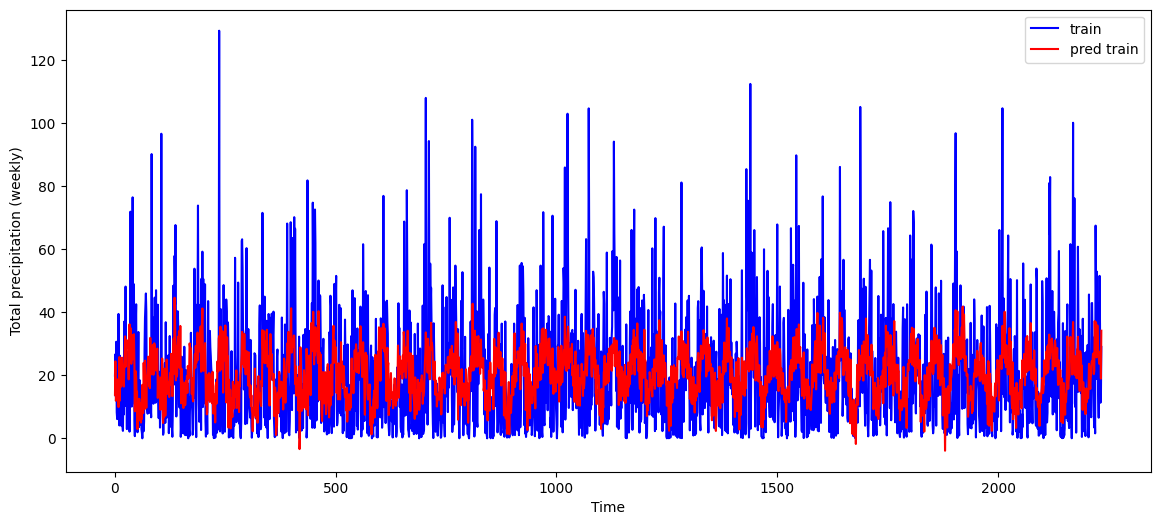

In [81]:
data = get_dataset(df, *objfunc.convert_solution_to_data(solution))
model = LinearRegression()
print(f"Size of dataset: {data.shape}")
print("-"*40)
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(data, model)):
    print(f"{name}: \t{val}")
plot_model(data, model)

In [40]:
cro = CRO_SL(objfunc, operators, params)
solution, obj_value = cro.optimize()

data = get_dataset(df, np.reshape(solution[:objfunc.size // 2], (n_attrs, K)), np.reshape(solution[objfunc.size // 2:], (n_attrs, K)))
model = LinearRegression()
print(f"Size of dataset: {data.shape}")
print("-"*40)
for name, val in zip(['error_train    ', 'error_cv_train', 'error_cv_test  ', 'error_test    '], get_mse(data, model)):
    print(f"{name}: \t{val}")
plot_model(data, model)

NameError: name 'CRO_SL' is not defined

In [ ]:
cro.display_report()